In [1]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization
#from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
#from keras.layers.merge import Concatenate
from tensorflow.keras.layers import concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

#from keras.utils import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#from keras.utils.multi_gpu_utils import multi_gpu_model
#from tensorflow.keras.utils import multi_gpu_model

In [2]:
path = "./signatures"
print(os.getcwd())
tf.__version__ 

C:\Users\sveda\Documents\Github\startechies


'2.9.1'

### Data Preprocessing

Note: All the png images are already Salt and Pepper denoised and Normalized

In [3]:
# Creating lists of Genuine and fake signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored in the list "forged_groups"
# Each person has 24 forged and 24 original examples
from natsort import natsorted, ns
orig_groups, forg_groups = [], []
images = os.listdir(path+"/full_forg")
images=natsorted(images, alg=ns.IGNORECASE)
images = [path+"/full_forg"+'/'+x for x in images]
for i in range(0,len(images)-1,24):
  forg_groups.append(images[i:i+24]) 
images = os.listdir(path+"/full_org")
images=natsorted(images, alg=ns.IGNORECASE)
images = [path+"/full_org"+'/'+x for x in images]
for i in range(0,len(images)-1,24):
  orig_groups.append(images[i:i+24])

In [4]:
# Quick check to confirm we have data of all the 55 individuals
len(orig_groups), len(forg_groups)

(55, 55)

In [5]:
print(orig_groups)     # it is a list of lists

[['./signatures/full_org/original_1_1.png', './signatures/full_org/original_1_2.png', './signatures/full_org/original_1_3.png', './signatures/full_org/original_1_4.png', './signatures/full_org/original_1_5.png', './signatures/full_org/original_1_6.png', './signatures/full_org/original_1_7.png', './signatures/full_org/original_1_8.png', './signatures/full_org/original_1_9.png', './signatures/full_org/original_1_10.png', './signatures/full_org/original_1_11.png', './signatures/full_org/original_1_12.png', './signatures/full_org/original_1_13.png', './signatures/full_org/original_1_14.png', './signatures/full_org/original_1_15.png', './signatures/full_org/original_1_16.png', './signatures/full_org/original_1_17.png', './signatures/full_org/original_1_18.png', './signatures/full_org/original_1_19.png', './signatures/full_org/original_1_20.png', './signatures/full_org/original_1_21.png', './signatures/full_org/original_1_22.png', './signatures/full_org/original_1_23.png', './signatures/full

### Train-Validation-Test Split
. Signatures of 42 people are used for training
. Signatures of 7 people are used for validation
. Signatures of 6 people are used for testing

In [6]:
orig_train, orig_val, orig_test = orig_groups[:42], orig_groups[42:49], orig_groups[49:55]
forg_train, forg_val, forg_test = forg_groups[:42], forg_groups[42:49], forg_groups[49:55]

In [9]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

In [10]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        genuine_labels = []
        forged_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have 
        # 24 choose 2 = 276 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 24 * 12 = 300 Genuine-Forged image pairs for one person.
        # In all we have 120 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 120 * 276 = 33120
        # Total number of Genuine-Forged pairs = 120 * 300 = 36000
        # Total no. of data points = 33120 + 36000 = 69120
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        genuine_labels = [1]*len(orig_pairs)
        forged_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = genuine_labels + forged_labels
        del orig_pairs, forg_pairs, genuine_labels, forged_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.
            
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            
            '''Converting white patches to 255 pixel and black patches to 0 pixel for increasing accuracy'''
            for i in range(img1.shape[0]):
              for j in range(img1.shape[1]):
                pixel = img1.item(i, j)
                if pixel > 200:
                  img1[i][j]=255
                else:
                  img1[i][j]=0
            for i in range(img2.shape[0]):
              for j in range(img2.shape[1]):
                pixel = img2.item(i, j)
                if pixel > 200:
                  img2[i][j]=255
                else:
                  img2[i][j]=0
                
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            #print(img1)
            #print(np.isnan(img1).any())
            img2 = img2[..., np.newaxis]
            #print(np.isnan(img2).any())
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

In [21]:
# def euclidean_distance(vects):
#     '''Compute Euclidean Distance between two vectors'''
#     x, y = vects
#     #return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))
#     sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
#     return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [22]:
# def eucl_dist_output_shape(shapes):
#     shape1, shape2 = shapes
#     return (shape1[0], 1)

In [23]:
#function tries to calculate the loss for genuine-genuine pairs by computing the euclidean distance 
#and the genuine-forged pairs by calculating the distance of the euclidean distance of the forged signature from the marginal boundary of the genuine signatures
# def contrastive_loss(y_true, y_pred):
#     margin = 1
#    #return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

#     square_pred = tf.math.square(y_pred)
#     margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
#     return tf.math.reduce_mean(
#             (1 - y_true) * square_pred + (y_true) * margin_square
#         )

In [11]:
#Image dimensions
input_shape=(155, 220, 1)
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''

    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2)))

    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1)))

    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1))
    seq.add(ZeroPadding2D((1, 1)))

    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, activation='relu'))
    seq.add(Dropout(0.5))

    seq.add(Dense(128, activation='relu')) # softmax changed to relu

    return seq

# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
# distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

out = tf.keras.layers.concatenate([processed_a,processed_b],axis=1)
out = tf.keras.layers.Dense(512,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.1))(out)
out = tf.keras.layers.Dense(64,activation='relu')(out)

out = tf.keras.layers.Dense(1,activation='sigmoid',name='Output')(out)

model = Model([input_a, input_b], out)

# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss='binary_crossentropy', optimizer=rms, metrics=["accuracy"])

In [12]:
batch_sz = 128
num_train_samples = 276*42 + 300*42
num_val_samples =  276*7 + 300*7 
num_test_samples =276*6 + 300*6 
num_train_samples, num_val_samples, num_test_samples

(24192, 4032, 3456)

In [13]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('./models/signaturemodel-{epoch:03d}.h5')
]

In [14]:
results = model.fit(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 100,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

Epoch 1/100
189/189 [==============================] - 1702s 9s/step - loss: 25.1762 - accuracy: 0.5989 - val_loss: 17.3391 - val_accuracy: 0.7382 - lr: 1.0000e-04
Epoch 2/100
189/189 [==============================] - 1847s 10s/step - loss: 11.9186 - accuracy: 0.8415 - val_loss: 7.9809 - val_accuracy: 0.6111 - lr: 1.0000e-04
Epoch 3/100
189/189 [==============================] - 1831s 10s/step - loss: 4.7270 - accuracy: 0.9490 - val_loss: 3.2018 - val_accuracy: 0.7641 - lr: 1.0000e-04
Epoch 4/100
189/189 [==============================] - 1908s 10s/step - loss: 1.4689 - accuracy: 0.9844 - val_loss: 1.6490 - val_accuracy: 0.6096 - lr: 1.0000e-04
Epoch 5/100
189/189 [==============================] - 1826s 10s/step - loss: 0.4318 - accuracy: 0.9903 - val_loss: 1.2629 - val_accuracy: 0.7538 - lr: 1.0000e-04
Epoch 6/100
189/189 [==============================] - 1573s 8s/step - loss: 0.2149 - accuracy: 0.9925 - val_loss: 1.1925 - val_accuracy: 0.7807 - lr: 1.0000e-04
Epoch 7/100
189/189 [

KeyboardInterrupt: 

#### Validation Loss is increasing hence not training further...epoch 8 model provides least validation loss and good valiidation accuracy...hence will be using it for testing


In [16]:
model = load_model('./models/signaturemodel-008.h5')

In [17]:
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


In [24]:
print(np.array(pred).shape)

(3456,)


In [25]:
np.array(pred)

array([2.1588667e-01, 9.7604737e-12, 6.9071573e-01, ..., 4.9792856e-02,
       5.5803734e-01, 1.8279380e-01], dtype=float32)

In [27]:
import sklearn.metrics as metrics
fpr, tpr, thresholds = metrics.roc_curve(np.array(tr_y), np.array(pred))
print(tpr)
print(fpr)
print(thresholds)

[0.         0.08486647 0.09139466 0.09732938 0.09970326 0.10267062
 0.10445104 0.10504451 0.1074184  0.10919881 0.11038576 0.11097923
 0.11454006 0.11513353 0.11691395 0.11810089 0.11928783 0.11988131
 0.12106825 0.12462908 0.12581602 0.13115727 0.13353116 0.1388724
 0.14005935 0.14302671 0.14421365 0.14540059 0.14658754 0.16261128
 0.16379822 0.18397626 0.1851632  0.18991098 0.18991098 0.21068249
 0.21068249 0.21186944 0.21305638 0.21780415 0.2189911  0.22492582
 0.22492582 0.23323442 0.23323442 0.23560831 0.23560831 0.23620178
 0.23620178 0.23857567 0.23976261 0.24332344 0.24332344 0.24866469
 0.24866469 0.25222552 0.25222552 0.25281899 0.25281899 0.25341246
 0.25341246 0.25519288 0.25637982 0.26587537 0.26587537 0.26646884
 0.26646884 0.26884273 0.26884273 0.2735905  0.2735905  0.28130564
 0.28130564 0.28664688 0.28783383 0.3074184  0.3074184  0.30860534
 0.30860534 0.31097923 0.31097923 0.31394659 0.31394659 0.31632047
 0.31632047 0.32818991 0.32818991 0.33353116 0.33353116 0.34183

In [31]:
print(metrics.roc_auc_score(np.array(tr_y), np.array(pred)))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

0.8890006651843835
Threshold value is: 0.3270535


In [32]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    prob = result[0][0]
    print("Probability Score = ", prob)
    if prob < optimal_threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

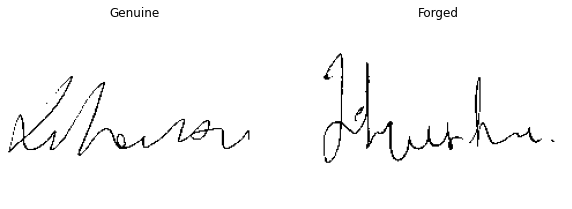

1/1 [==============================] - 0s 24ms/step
Probability Score =  0.009233845
Its a Forged Signature


In [33]:
predict_score()

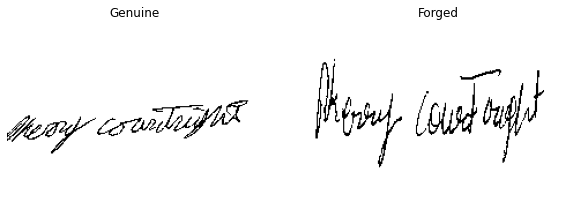

1/1 [==============================] - 0s 24ms/step
Probability Score =  0.00014273694
Its a Forged Signature


In [35]:
predict_score()

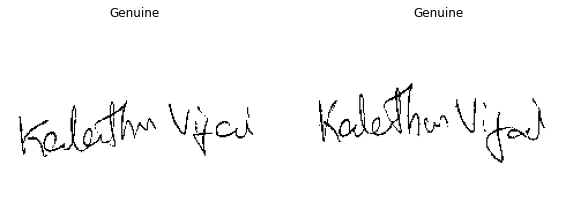

1/1 [==============================] - 0s 23ms/step
Probability Score =  0.46356952
Its a Genuine Signature


In [36]:
predict_score()

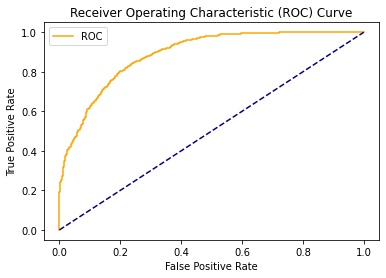

In [37]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
plot_roc_curve(fpr, tpr)

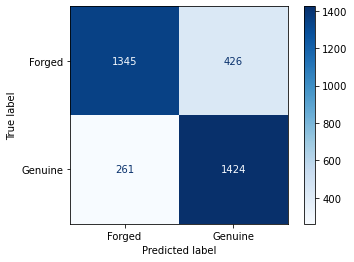

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

labels = ["Forged", "Genuine"]

x = np.array(pred)

# Obtain array of square of each element in x
pred_label = lambda p:1 if p > 0.32705 else 0
pred_y = np.array([pred_label(xi) for xi in x])
cm = confusion_matrix(tr_y, pred_y)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [41]:
test_accuracy = (1345 + 1424)/(1345+426+1424 +261)

In [42]:
print(test_accuracy)

0.8012152777777778


In [1]:
precision = 1424/(1424+426)
print(precision)

0.7697297297297298


In [2]:
recall = 1424/(1424+261)
print(recall)

0.8451038575667655
